### imports 

In [9]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, TensorDataset

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_name = 'full-notebook'
wandb.init(
    project="New-Radar-diffusion",
    name=run_name,
    notes="Regular diffusion. this experiment is our benchmark - we check if changes are performing better or worse",
    config={
        "SNR": 10,
        "CNR": 15,
        "beta_end": 0.02,
        "beta_start": 1e-4,
        "batch_size": 16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "dataset_size": 50000,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run s2em1h6t was previously created an

BrokenPipeError: [Errno 32] Broken pipe

## dataset

In [11]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets, random_n_targets, nu=None, scnr=None, snr=None, cnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.snr_dB = snr
        self.cnr_dB = cnr
        self.scnr = scnr
        self.nu = torch.tensor([nu], dtype=torch.float) if nu is not None else None

        # Radar parameters
        self.N = 64       # fast–time samples per pulse
        self.K = 64       # slow–time pulses per frame
        self.B = 50e6     # Chirp bandwidth (Hz)
        self.T0 = 1e-3    # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8      # Speed of light (m/s)
        self.CNR = 15     # in dB (only used if snr/cnr are NOT given)

        # Range and Doppler settings
        self.r_min, self.r_max = 0, 189    # meters
        self.v_min, self.v_max = -7.8, 7.8   # m/s (for targets)
        self.vc_min, self.vc_max = -7.8, 7.8 # m/s (for clutter)
        self.dr = 3       # Range resolution in m
        self.dv = 0.249   # Doppler resolution in m/s

        # Range and Doppler bins (for label maps)
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)
        self.dV = len(self.V)

        # Noise power calculation (only used if snr/cnr not specified)
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10))
        
        # For old scnr logic, we also computed a "normalization" factor
        self.cn_norm = torch.sqrt(
            torch.tensor(
                self.N * self.K * (self.N // 2 + self.sigma2), dtype=torch.float
            )
        )

    def generate_target_signal(self, ranges, velocities, phases, gains_dB):
        """
        Creates the raw (unscaled) target signals for each target,
        then (if old scnr approach) scales them to achieve the desired scnr in dB,
        or returns them raw for later scaling if snr/cnr approach is used.
        """
        # Range steering vector (one per target)
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N, dtype=torch.float)))
        
        # Doppler steering vector (one per target)
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K, dtype=torch.float)))
        
        # Form the fast–time × slow–time target signature for each target
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)
        rd_signal = rd_signal * torch.exp(1j * phases)  # impart random phase per target
        
        # If we are using the old SCNR approach, scale immediately
        # Gains in dB => each target’s SCNR
        if (self.snr_dB is None) or (self.cnr_dB is None):
            # Old approach: sum all scaled targets into a single matrix
            S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
            sig_amp = (10 ** (gains_dB / 20)) * (self.cn_norm / S_norm)
            rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)
            return rd_signal
        else:
            # With the new approach, we do NOT scale by SCNR here.
            # We return the raw sum across all targets, for later power-based scaling.
            rd_signal = rd_signal.sum(dim=0)
            return rd_signal

    def generate_clutter(self, nu):
        # Choose a clutter velocity uniformly within the allowed limits
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = 2 * torch.pi * (2 * self.fc * clutter_vel) / self.c 
        sigma_f = 0.05  # Correlation parameter (from the referenced paper)

        p, q = torch.meshgrid(
            torch.arange(self.N, dtype=torch.float),
            torch.arange(self.K, dtype=torch.float),
            indexing='ij'
        )
        # M is the covariance-like matrix for correlated clutter
        M = torch.exp(
            -2 * torch.pi**2 * sigma_f**2 * (p - q)**2
            - 1j * (p - q) * fd * self.T0
        )

        # Draw complex Gaussian
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        e, V_mat = torch.linalg.eigh(M)  # eigen-decomposition
        e_sqrt = torch.sqrt(torch.clamp(e.real, min=0.0))
        E = torch.diag(e_sqrt)
        A = V_mat @ E.to(V_mat.dtype)
        w_t = A @ z  # shaping the random draws to match M

        # Impart heavy–tailed behavior via Gamma modulation (shape = scale = nu)
        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast–time × slow–time representation
        # using a range–steering operation.
        c_r_steer = torch.exp(
            -1j 
            * 2 
            * torch.pi 
            * torch.outer(torch.arange(self.N, dtype=torch.float), self.R)
            * (2 * self.B) / (self.c * self.N)
        )
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        """
        Generate one radar data frame, label map, and the separate S, C, W
        so that we can control SNR and CNR (if specified).
        """
        # 1. Generate unscaled noise (mean 0, unit variance in each real/imag component).
        #    We'll measure it and scale later if snr/cnr is used.
        W_unscaled = torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))
        
        # 2. Generate unscaled clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C_unscaled = self.generate_clutter(nu)
        
        # 3. Prepare to generate target signal(s)
        #    We'll choose random targets if with_targets == True
        S_unscaled = torch.zeros(self.N, self.K, dtype=torch.cfloat)
        rd_label = torch.zeros(self.dR, self.dV)

        if self.with_targets:
            n = (
                torch.randint(1, self.n_targets + 1, (1,)).item()
                if self.random_n_targets
                else self.n_targets
            )
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            
            # If new SNR/CNR approach is NOT used, we fallback to scnr or [-5, 10] dB random
            if (self.snr_dB is None) or (self.cnr_dB is None):
                SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
                S_unscaled = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)
            else:
                # Just pass dummy dB array here; we won't scale inside 'generate_target_signal'
                # Instead, we will do the scaling outside
                S_raw = []
                for i in range(n):
                    # Each target can have the same 'gain' placeholder
                    s_i = self.generate_target_signal(
                        ranges[i].unsqueeze(-1),
                        velocities[i].unsqueeze(-1),
                        phases[i].unsqueeze(-1),
                        gains_dB=torch.tensor([0.0])  # placeholder
                    )
                    S_raw.append(s_i)
                # Sum all targets
                S_unscaled = sum(S_raw)

            # For each target, mark the closest range and Doppler bin.
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        # ---------------------------
        # NEW: If snr & cnr are given, do amplitude scaling here
        # ---------------------------
        if (self.snr_dB is not None) and (self.cnr_dB is not None):
            # 1) measure raw powers
            noise_power  = W_unscaled.abs().pow(2).mean()
            clutter_power= C_unscaled.abs().pow(2).mean() if C_unscaled.numel() > 0 else 0.0
            signal_power = S_unscaled.abs().pow(2).mean() if S_unscaled.numel() > 0 else 0.0

            # 2) define desired linear ratios
            snr_lin = 10 ** (self.snr_dB / 10)
            cnr_lin = 10 ** (self.cnr_dB / 10)

            # 3) define desired final powers
            #    We'll anchor the noise to "1.0" average power for convenience
            #    (or you could anchor it to some other power). Then scale clutter & signal.
            #    Step (A): Scale noise to final_noise_power = 1.0
            #             => alpha_n = sqrt(1 / noise_power).
            alpha_n = torch.sqrt(1.0 / noise_power)
            W = alpha_n * W_unscaled  # final noise
            final_noise_power = W.abs().pow(2).mean()

            #    Step (B): Clutter should have average power = cnr_lin * final_noise_power
            if clutter_power > 0:
                alpha_c = torch.sqrt((cnr_lin * final_noise_power) / clutter_power)
                C = alpha_c * C_unscaled
            else:
                C = torch.zeros_like(C_unscaled)

            #    Step (C): Signal should have average power = snr_lin * final_noise_power
            if signal_power > 0:
                alpha_s = torch.sqrt((snr_lin * final_noise_power) / signal_power)
                S = alpha_s * S_unscaled
            else:
                S = torch.zeros_like(S_unscaled)

        else:
            W = (W_unscaled / torch.sqrt(torch.tensor(self.sigma2)))  # old approach
            C = C_unscaled
            S = S_unscaled

        X = S + C + W
        
        signal_energy  = S.abs().pow(2).sum()
        clutter_energy = C.abs().pow(2).sum()
        noise_energy   = W.abs().pow(2).sum()
        scnr_lin = signal_energy / (clutter_energy + noise_energy + 1e-12)
        scnr_dB  = 10.0 * torch.log10(scnr_lin + 1e-12)

        return S, C, W, X, rd_label, scnr_dB

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        """
        Return the data and label for sample 'idx'.
        """
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = self.gen_frame_and_labels()
        return signal, clutter, gaus_noise, IQ, rd_label, scnr_dB
    


In [12]:
def get_mean_std(radarloader):
    IQ_total_sum = 0.0
    IQ_total_sq_sum = 0.0
    IQ_total_samples = 0
    signal_total_sum = 0.0
    signal_total_sq_sum = 0.0
    signal_total_samples = 0
    for signal, _, _, IQ, _, _ in radarloader:
        IQ_total_sum += IQ.real.sum() + IQ.imag.sum() #signal.abs().sum()
        IQ_total_sq_sum += (IQ.real.pow(2).sum() + IQ.imag.pow(2).sum()) #(signal.abs()**2).sum()
        IQ_total_samples += IQ.numel() * 2 # multiply by 2 for real and imaginary 
        signal_total_sum += signal.real.sum() + signal.imag.sum() #signal.abs().sum()
        signal_total_sq_sum += (signal.real.pow(2).sum() + signal.imag.pow(2).sum()) #(signal.abs()**2).sum()
        signal_total_samples += signal.numel() * 2 # multiply by 2 for real and imaginary 
    IQ_mean = IQ_total_sum / IQ_total_samples
    IQ_std = torch.sqrt((IQ_total_sq_sum / IQ_total_samples) - IQ_mean**2)
    signal_mean = signal_total_sum / signal_total_samples
    signal_std = torch.sqrt((signal_total_sq_sum / signal_total_samples) - signal_mean**2)
    return signal_mean, signal_std, IQ_mean, IQ_std



In [13]:

def normalize_and_cache_dataset(dataset, signal_mean, signal_std, IQ_mean, IQ_std):
    signals_norm = []
    IQs_norm = []
    labels = []
    scnr_dBs = []
    clutter_all = []  # <- added
    gauss_all = []    # <- added

    for idx in tqdm(range(len(dataset)), desc='Normalizing dataset'):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = dataset[idx]

        # Normalize signal
        signal_real_norm = (signal.real - signal_mean) / signal_std
        signal_imag_norm = (signal.imag - signal_mean) / signal_std
        signal_norm = torch.complex(signal_real_norm, signal_imag_norm)
        
        # Normalize IQ
        IQ_real_norm = (IQ.real - IQ_mean) / IQ_std
        IQ_imag_norm = (IQ.imag - IQ_mean) / IQ_std
        IQ_norm = torch.complex(IQ_real_norm, IQ_imag_norm)

        signals_norm.append(signal_norm)
        IQs_norm.append(IQ_norm)
        labels.append(rd_label)
        scnr_dBs.append(scnr_dB)
        
        # Save clutter and gauss tensors as well
        clutter_all.append(clutter)      # <- added
        gauss_all.append(gaus_noise)     # <- added

    # Stack everything into tensors
    signals_norm = torch.stack(signals_norm)
    IQs_norm = torch.stack(IQs_norm)
    labels = torch.stack(labels)
    scnr_dBs = torch.tensor(scnr_dBs)
    clutter_all = torch.stack(clutter_all)  # <- added
    gauss_all = torch.stack(gauss_all)      # <- added

    # Return cached TensorDataset (now consistent)
    return TensorDataset(signals_norm, clutter_all, gauss_all, IQs_norm, labels, scnr_dBs)


In [14]:
def prep_dataset(config):
    train_dataset_with_targets = RadarDataset(num_samples=config.dataset_size, n_targets=8, random_n_targets=True, snr=config.SNR, cnr=config.CNR)
    train_dataset_without_targets = RadarDataset(num_samples=config.dataset_size//10, n_targets=0, random_n_targets=False, snr=config.SNR, cnr=config.CNR)
    full_train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_without_targets])
    val_dataset_with_targets = RadarDataset(num_samples=config.dataset_size//10, n_targets=8, random_n_targets=True, snr=config.SNR, cnr=config.CNR)
    val_dataset_without_targets = RadarDataset(num_samples=config.dataset_size//100, n_targets=0, random_n_targets=False, snr=config.SNR, cnr=config.CNR)
    full_val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_without_targets])
    train_loader = DataLoader(full_train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(full_val_dataset, batch_size=config.batch_size, shuffle=False)
    signal_mean, signal_std, IQ_mean, IQ_std = get_mean_std(train_loader)
    norm_train_dataset = normalize_and_cache_dataset(full_train_dataset, signal_mean, signal_std, IQ_mean, IQ_std)
    norm_val_dataset = normalize_and_cache_dataset(full_val_dataset, signal_mean, signal_std, IQ_mean, IQ_std)
    norm_train_loader = DataLoader(norm_train_dataset, batch_size=config.batch_size, shuffle=True)
    norm_val_loader = DataLoader(norm_val_dataset, batch_size=config.batch_size, shuffle=False)
    return train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset


In [15]:
train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset = prep_dataset(config)

Normalizing dataset: 100%|██████████| 5500/5500 [00:14<00:00, 376.79it/s]


## Unet

In [23]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb_factor = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb_factor)
        emb = x[:, None] * emb[None, :]  # shape: (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb  # shape: (B, dim)

# Self-attention block operating on 2D features.
class SelfAttention2d(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)  # (B, 3C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)

        # Reshape for multi-head attention.
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) / math.sqrt(C // self.num_heads)
        attn = torch.softmax(attn, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return x + out  # Residual connection

# A Double Convolution block with two convs (with GroupNorm and SiLU activation)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_ch),
            nn.SiLU()
        )
    def forward(self, x):
        return self.double_conv(x)

# Downsample with a double conv, then max pooling.
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down

# Upsample with transpose convolution, concatenation of skip connection, and double conv.
class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Adjust spatial dims if needed.
        if x.size() != skip.size():
            diffY = skip.size(2) - x.size(2)
            diffX = skip.size(3) - x.size(3)
            x = F.pad(x, [0, diffX, 0, diffY])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

# The refined conditional U-Net for diffusion denoising.
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, time_emb_dim=256):
        """
        in_channels=4: concatenated [x_t_real, x_t_imag, cond_real, cond_imag]
        out_channels=2: predicting noise for real and imaginary parts.
        time_emb_dim: dimensionality of time embeddings.
        """
        super().__init__()
        # Time embedding network with two linear layers.
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        # Encoder
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        # Inject self-attention at intermediate scales.
        self.attn1 = SelfAttention2d(128)  # after first down
        self.attn2 = SelfAttention2d(256)  # after second down
        # Bottleneck (with extra capacity and attention)
        self.bot = DoubleConv(256, 512)
        self.bot_attn = SelfAttention2d(512)
        # Decoder with time embeddings injected at multiple scales.
        self.up1 = Up(512, skip_channels=256, out_channels=256)
        self.up2 = Up(256, skip_channels=256, out_channels=256)
        self.up3 = Up(256, skip_channels=128, out_channels=128)
        self.up4 = Up(128, skip_channels=64, out_channels=64)
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)
        # Linear projections for time embeddings at different stages.
        self.time_proj_bot = nn.Linear(time_emb_dim, 512)
        self.time_proj_up1 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up2 = nn.Linear(time_emb_dim, 256)
        self.time_proj_up3 = nn.Linear(time_emb_dim, 128)

    def forward(self, x, t):
        """
        x: (B, 4, H, W) with channels [x_t_real, x_t_imag, cond_real, cond_imag]
        t: (B,) normalized timesteps.
        """
        # Compute time embedding.
        t_emb = self.time_emb(t)  # shape: (B, time_emb_dim)
        
        # Encoder
        x1 = self.inc(x)            # (B, 64, H, W)
        x2_skip, x2 = self.down1(x1)  # x2_skip: (B, 128, H, W); x2: (B, 128, H/2, W/2)
        x2_skip = self.attn1(x2_skip) # refine low-level features

        x3_skip, x3 = self.down2(x2)  # x3_skip: (B, 256, H/2, W/2); x3: (B, 256, H/4, W/4)
        x3_skip = self.attn2(x3_skip) # additional attention at this scale

        x4_skip, x4 = self.down3(x3)  # x4_skip: (B, 256, H/4, W/4); x4: (B, 256, H/8, W/8)
        
        # Bottleneck
        x_bot = self.bot(x4)
        x_bot = self.bot_attn(x_bot)
        # Add time embedding for the bottleneck.
        t_bot = self.time_proj_bot(t_emb).view(-1, 512, 1, 1)
        x_bot = x_bot + t_bot
        
        # Decoder with skip connections and time embedding injections.
        x = self.up1(x_bot, x4_skip)  # (B, 256, H/4, W/4)
        t_up1 = self.time_proj_up1(t_emb).view(-1, 256, 1, 1)
        x = x + t_up1
        
        x = self.up2(x, x3_skip)      # (B, 256, H/2, W/2)
        t_up2 = self.time_proj_up2(t_emb).view(-1, 256, 1, 1)
        x = x + t_up2
        
        x = self.up3(x, x2_skip)      # (B, 128, H, W)
        t_up3 = self.time_proj_up3(t_emb).view(-1, 128, 1, 1)
        x = x + t_up3
        
        x = self.up4(x, x1)           # (B, 64, H, W)
        output = self.outc(x)
        return output


## diffusion

In [24]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConditionalDiffusion(nn.Module):
    def __init__(self, model, scheduler_type="linear", T=1000, beta_start=1e-4, beta_end=0.02):
        super().__init__()
        self.model = model
        self.T = T

        if scheduler_type == "linear":
            betas = torch.linspace(beta_start, beta_end, T)
        elif scheduler_type == "cosine":
            betas = torch.cos(torch.linspace(0, math.pi / 2, T)) ** 2
            betas = (betas - betas.min()) / (betas.max() - betas.min())
            betas = beta_start + (beta_end - beta_start) * betas
        else:
            raise ValueError(f"Unknown scheduler type: {scheduler_type}")
        
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", 1.0 - betas)
        self.register_buffer("alpha_bars", torch.cumprod(self.alphas, dim=0))

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alphas_bar = self.alpha_bars[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_bar = (1 - self.alpha_bars[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alphas_bar * x0 + sqrt_one_minus_alphas_bar * noise, noise
    
    def p_losses(self, x0, t, cond):
        x_noisy, noise = self.q_sample(x0, t)
        t_norm = t.float() / self.T
        model_input = torch.cat([x_noisy, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)
        return F.mse_loss(noise_pred, noise)
    
    @torch.no_grad()
    def p_sample(self, x, t, cond):
        t_int = t.item() if isinstance(t, torch.Tensor) else t
        betas_t = self.betas[t_int].view(-1, 1, 1, 1)
        alphas_t = self.alphas[t_int].view(-1, 1, 1, 1)
        alpha_bars_t = self.alpha_bars[t_int].view(-1, 1, 1, 1)
        t_norm = (torch.tensor([t_int], device=x.device).float() / self.T).repeat(x.shape[0])

        model_input = torch.cat([x, cond], dim=1)
        noise_pred = self.model(model_input, t_norm)

        coef1 = 1 / torch.sqrt(alphas_t)
        coef2 = betas_t / torch.sqrt(1-alpha_bars_t)
        mean = coef1 * (x - coef2 * noise_pred)
        noise=torch.randn_like(x) if t_int > 0 else 0
        return mean + torch.sqrt(betas_t) * noise
    
    @torch.no_grad()
    def sample(self, cond, shape):
        x = torch.randn(shape, device=cond.device)
        for t in reversed(range(self.T)):
            t_tensor = torch.tensor([t], device=x.device)
            x = self.p_sample(x, t_tensor, cond)
        return x


In [25]:
import math
import torch
import torch.nn.functional as F

def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map_differentiable(IQ_map):
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    dev = IQ_map.device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    return RD_map


def train_one_epoch(diffusion, dataloader, optimizer, device, use_standard_loss=True, use_rd_loss=False):
    diffusion.train()
    epoch_loss = 0
    e_rd_loss = 0
    e_mse_loss = 0
    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch

        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        # Concatenate to form 2-channel tensors.
        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)   # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)

        # Sample random timesteps for diffusion.
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        
        # Compute loss.
        #rd_fac = 1e-9
        #rd_loss = diffusion.rd_losses(x0, t, cond)
        # rd_loss = diffusion.rd_soft_loss(x0, t, cond, threshold=100, temperature=0.1, rd_loss_scale=0.5)
        loss = diffusion.p_losses(x0, t, cond)
        # e_rd_loss += rd_loss.item()
        # e_mse_loss += mse_loss.item()
        # loss = mse_loss + rd_loss #* rd_fac
        #loss = diffusion.p_losses_rd_label(x0, t, cond, rd_label)
#        loss = diffusion.combined_loss(x0, t, cond, use_standard_loss, use_rd_loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)#, e_mse_loss/ len(dataloader), e_rd_loss/ len(dataloader)


@torch.no_grad()
def validate(diffusion, dataloader, device, use_standard_loss=True, use_rd_loss=False):
    diffusion.eval()
    total_val_loss = 0
    iq_val_loss = 0
    rd_val_loss = 0
    gen_mse, gen_psnr = None, None

    for i, batch in enumerate(dataloader):
        signal, clutter, gaus_noise, IQ, rd_label, scnr_dB = batch
        
        if signal.real.ndim == 3:
            x0_real = signal.real.unsqueeze(1)
            x0_imag = signal.imag.unsqueeze(1)
            cond_real = IQ.real.unsqueeze(1)
            cond_imag = IQ.imag.unsqueeze(1)
        else:
            x0_real = signal.real
            x0_imag = signal.imag
            cond_real = IQ.real
            cond_imag = IQ.imag

        x0 = torch.cat([x0_real, x0_imag], dim=1).to(device)  # (B,2,H,W)
        cond = torch.cat([cond_real, cond_imag], dim=1).to(device)  # (B,2,H,W)
        
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device).long()
        #rd_loss = diffusion.rd_losses(x0, t, cond, threshold=100, rd_loss_scale=10.0)
        # rd_loss = diffusion.rd_soft_loss(x0, t, cond, threshold=0.5, temperature=0.1, rd_loss_scale=0.5)
        iq_loss = diffusion.p_losses(x0, t, cond)
        # loss = rd_loss+iq_loss
        # iq_val_loss += iq_loss.item()
        # rd_val_loss += rd_loss.item()
        #loss = diffusion.combined_loss(x0, t, cond, use_standard_loss, use_rd_loss)
        total_val_loss += iq_loss.item()

        # For the first batch, generate a sample and compute metrics.
        if i == 0:
            generated = diffusion.sample(cond, x0.shape)
            mse_val = F.mse_loss(generated, x0).item()
            #rd_mse = F.mse_loss(create_rd_map_differentiable(generated), create_rd_map_differentiable(x0)).item()
            psnr_val = 20 * math.log10(x0.max().item() / math.sqrt(mse_val)) if mse_val > 0 else 100
            gen_mse, gen_psnr = mse_val, psnr_val

    avg_val_loss = total_val_loss / len(dataloader)
    return avg_val_loss, gen_mse, gen_psnr#, rd_mse#, iq_val_loss/ len(dataloader), rd_val_loss/ len(dataloader),

In [26]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

In [ ]:
best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []
e_mse_loss = None
e_rd_loss = None
iq_val_loss = None
rd_val_loss = None

for epoch in range(num_epochs):
    #train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    #val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, gen_mse, gen_psnr = validate(cond_diffusion, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), f"{run_name}.pth")
        print("   --> Best MSE model saved.")

    wandb.log({
        "total train loss": train_loss,
        "train mse loss": e_mse_loss if e_mse_loss is not None else float('nan'),
        "train rd loss": e_rd_loss if e_rd_loss is not None else float('nan'),
        "total val loss": val_loss,
        "IQ val loss": iq_val_loss if iq_val_loss is not None else float('nan'), 
        "RD val loss": rd_val_loss if rd_val_loss is not None else float('nan'),
        #"MSE between denoised RD and clean RD": rd_mse,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


In [20]:
import random
import torch
import matplotlib.pyplot as plt

def generate_range_steering_matrix(N=64, dR=64, B=50e6, c=3e8):
    rng_res = c / (2 * B)
    r_vals = torch.arange(dR) * rng_res
    n_vals = torch.arange(N)
    phase = -1j * 2 * torch.pi * (2 * B) / (c * N)
    R = torch.exp(phase * torch.outer(n_vals, r_vals))
    return R

def generate_doppler_steering_matrix(K=64, dV=64, fc=9.39e9, T0=1e-3, c=3e8):
    vel_res = c / (2 * fc * K * T0)
    v_vals = torch.linspace(-dV // 2, dV // 2, dV) * vel_res
    k_vals = torch.arange(K)
    phase = -1j * 2 * torch.pi * (2 * fc * T0) / c
    V = torch.exp(phase * torch.outer(k_vals, v_vals))
    return V

def create_rd_map(IQ_map):
    if not torch.is_tensor(IQ_map):
        IQ_map = torch.from_numpy(IQ_map)
    
    if not torch.is_complex(IQ_map):
        IQ_map = IQ_map.to(torch.complex64)
    
    dev = IQ_map.device
    R = generate_range_steering_matrix().to(dev)
    V = generate_doppler_steering_matrix().to(dev)
    RD_map = torch.abs(R.T.conj() @ IQ_map @ V.conj())
    RD_map = RD_map.clone().detach().resolve_conj().cpu()
    return RD_map

def run_inference(cond_diffusion , norm_val_dataset, checkpoint, device):

    # 1. Instantiate the model with updated channels:
    #    - in_channels=4 (for [signal_real, signal_imag, IQ_real, IQ_imag])
    #    - out_channels=2 (predicting the real and imaginary parts)
    # cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=32).to(device)
    # cond_diffusion = ConditionalDiffusion(model=cond_unet, T=1000, beta_start=1e-4, beta_end=0.02).to(device)

    # # 2. Load the saved best checkpoint
    checkpoint_path = checkpoint
    cond_diffusion.load_state_dict(torch.load(checkpoint_path, map_location=device))
    cond_diffusion.eval()

    signal, C, W, IQ, _, _ =  norm_val_dataset[random.randint(1,50)] #RadarDataset(num_samples=100, n_targets=8, random_n_targets=True,snr=30, cnr=15)[0],
    
    # 4. Prepare the condition for the model:
    #    Convert the noisy IQ signal into a 2-channel tensor (real & imag)
    cond_img = torch.cat([IQ.real.unsqueeze(0), IQ.imag.unsqueeze(0)], dim=0)  # (2, H, W)
    cond_img = cond_img.unsqueeze(0).to(device)  # (1, 2, H, W)
    # The desired sample shape for the diffusion model is (1,2,H,W)
    sample_shape = (1, 2, IQ.shape[0], IQ.shape[1])

    # 5. Generate a denoised sample using the diffusion model
    with torch.no_grad():
        generated_sample = cond_diffusion.sample(cond_img, sample_shape)  # (1,2,H,W)

    # 6. Convert the generated 2-channel tensor into a complex tensor
    generated_complex = torch.complex(generated_sample[0,0,:,:], generated_sample[0,1,:,:])
    

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [signal, IQ, generated_complex.cpu()],
                            ["Clean IQ Map", "Noise Map", "Denoised IQ Map (Conditional)"]):
        im = ax.imshow(abs(img), cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [create_rd_map(signal), create_rd_map(IQ), create_rd_map(generated_complex)],
                            ["Clean RD Map", "Noisy RD Map", "Denoised RD Map (Conditional)"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, img, title in zip(axes,
                            [-create_rd_map(generated_complex)+create_rd_map(IQ),
                            create_rd_map(C)+create_rd_map(W),
                            create_rd_map(C)+create_rd_map(W) - (create_rd_map(IQ)-create_rd_map(generated_complex))],
                            ["Predicted Noise", "Added Noise", "Added − Predicted"]):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

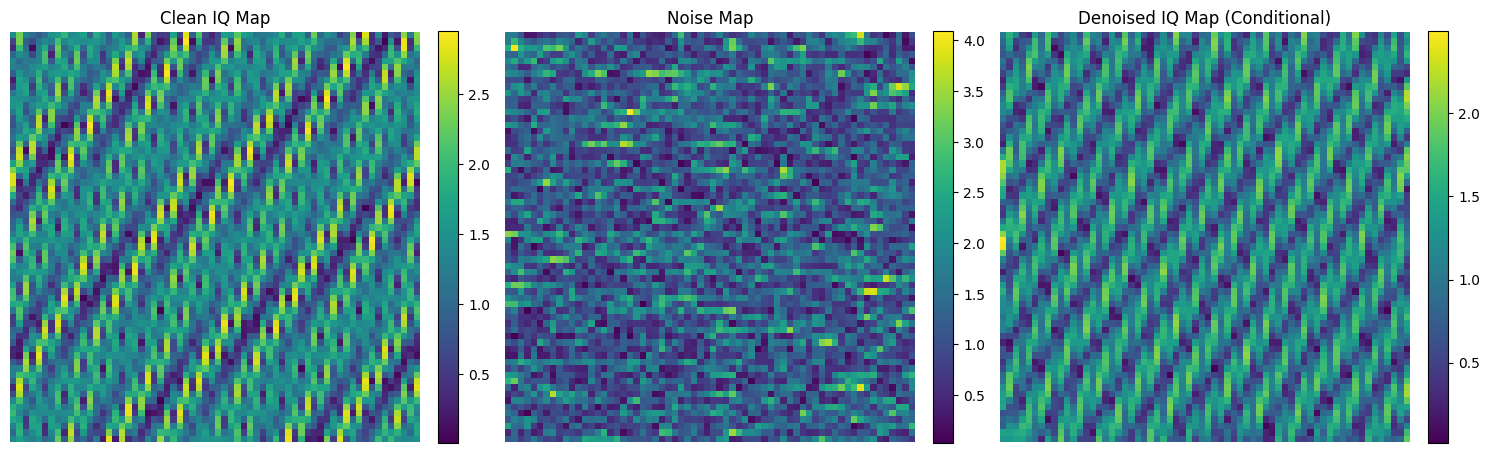

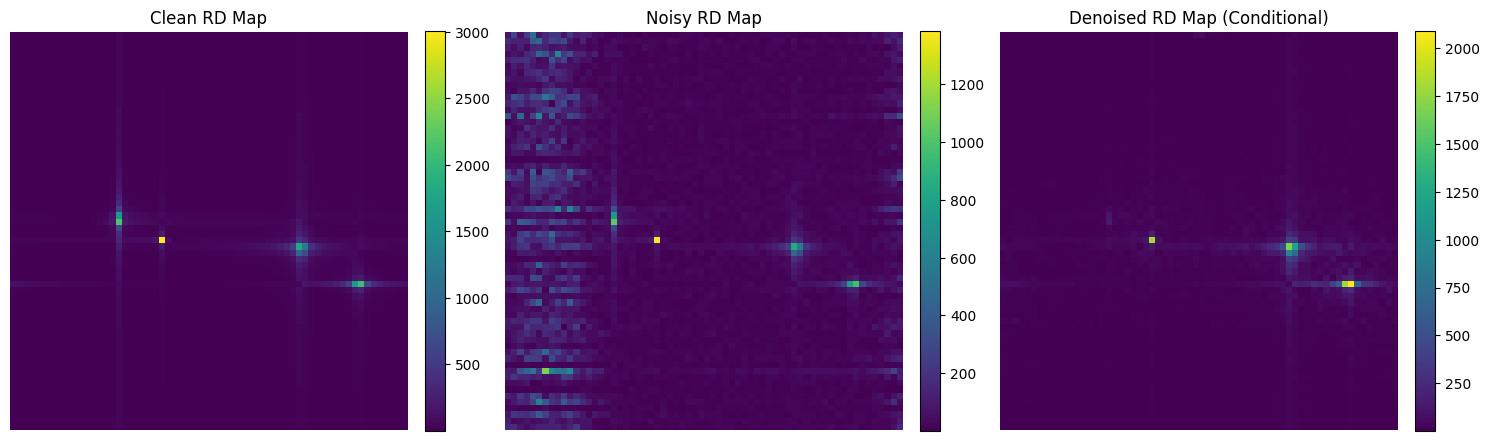

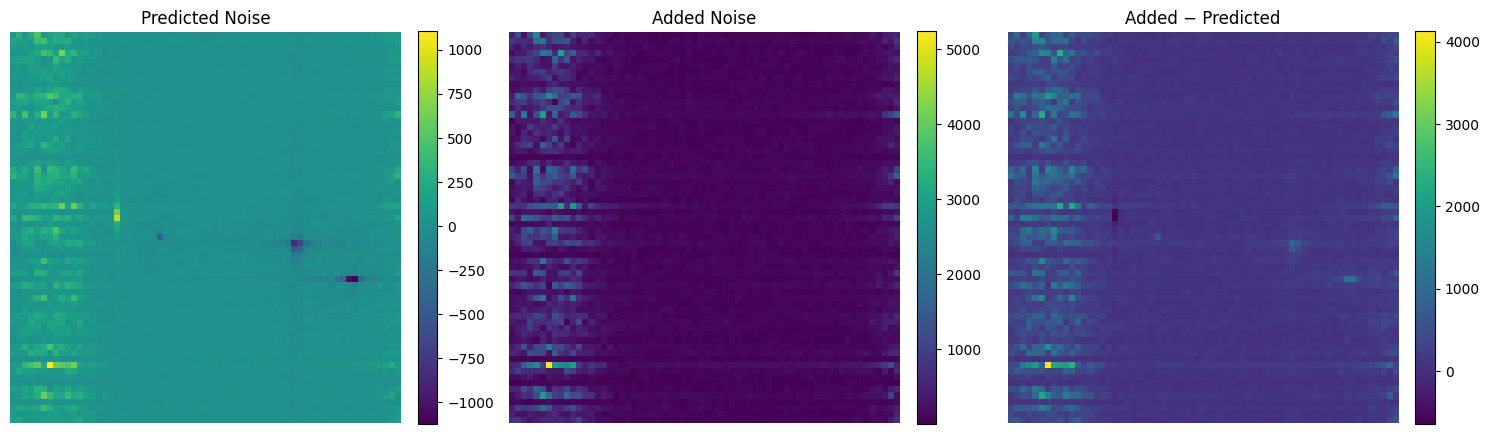

In [32]:
checkpoint_path = "/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/finalDiffusion/try_bench_again_bend005.pth"
run_inference(cond_diffusion , norm_val_dataset, checkpoint_path, device)